# Web Scraping Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping Indeed and then building a binary predictor with a classifier.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Imports

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import pickle
import numpy as np

from nltk.corpus import stopwords 

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from lib.indeed_parsing import extract_posts, extract_posts_wo_salary
from lib.preprocessing import clean_salary, clean_text, standardize, extract_keywords_into_dummies, is_keyword_in_title_or_summary 
from lib.normalizing_city import map_city, suburban_vs_city
from lib.predict_salary import predict_salary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Cities to collect job posts from:

In [3]:
cities = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 
          'Seattle', 'Los+Angeles', 'Philadelphia', 'Atlanta', 
          'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 
          'Denver', 'Houston', 'Miami', 'Washington']

### Parse and Collect - Location, Comapny, Salary, Title, Description

In [4]:
#more = extract_posts(max_results_per_city=500, cities=cities)

In [5]:
more = pd.read_pickle('data/more.pkl')

In [6]:
df = pd.read_pickle('data/df.pkl')

In [7]:
df = df.append(more, ignore_index=True)

### Convert salary string to integer and averaging salary ranges if necessary

In [8]:
df['salary'] = df['salary'].apply(clean_salary)

In [9]:
df.dropna(inplace=True)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.reset_index(drop=True, inplace=True)

### Cleans texts from punctuations and numbers

In [12]:
df['company'] = df['company'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)
df['city'] = df['city'].astype(str)
df['state'] = df['state'].astype(str)

### Standardize words like: sr -> senior, jr -> junior

In [13]:
df['title'] = df['title'].apply(standardize)
df['summary'] = df['summary'].apply(standardize)

## Predicting salaries using Logistic Regression

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries

find salary percentile:
- below twentieth 20th
- between 20th and 85th 
- above 85th

### Our data has a normal distribution so I decided to split 1+- standard deviation

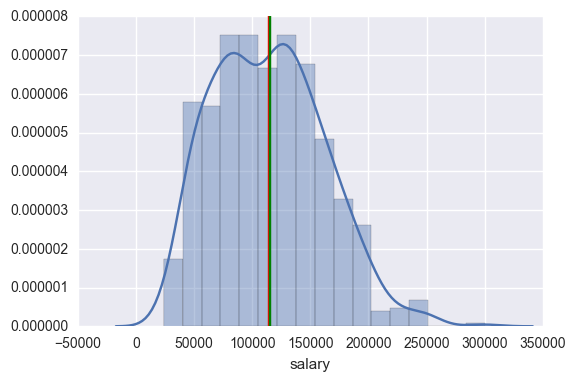

In [14]:
ax = sns.distplot(df['salary'])
ax.axvline(df['salary'].mean(), c='r')
ax.axvline(df['salary'].median(), c='g')

#### One standard deviation below and above 

In [15]:
twentieth = df['salary'].quantile(0.20)
eightyfifth = df['salary'].quantile(0.85)

In [16]:
def percentile_cls(row):
    salary = row['salary']
    
    if salary < twentieth:
        return 0
    elif salary >= twentieth and salary < eightyfifth:
        return 1 
    else:
        return 2

In [17]:
df['percentile_range'] = df.apply(percentile_cls, axis=1)

In [18]:
df.groupby(['percentile_range'])['salary'].describe()

percentile_range       
0                 count       125.000000
                  mean      51964.860000
                  std       10472.632261
                  min       24000.000000
                  25%       46000.000000
                  50%       52460.000000
                  75%       60000.000000
                  max       69673.000000
1                 count       417.000000
                  mean     115096.027578
                  std       26847.591605
                  min       70000.000000
                  25%       90000.000000
                  50%      119590.500000
                  75%      137500.000000
                  max      160000.000000
2                 count        96.000000
                  mean     191119.791667
                  std       24729.775872
                  min      162500.000000
                  25%      175000.000000
                  50%      182500.000000
                  75%      200000.000000
                  max      300000

### What is the baseline accuracy for this model?
class with majority count / total count 

In [19]:
baseline_accuracy = 417 / 638.0
print "Baseline Accuracy: %s" % (baseline_accuracy)

Baseline Accuracy: 0.653605015674


---

### Groupby percentile range to extract Latent Semantic Analysis from the text at each level

In [20]:
stops = set(stopwords.words('english'))

In [21]:
stops.update(['looking','using','work','working',
              'join','company','strong','challenge'])

In [22]:
stops = set([stop.decode('utf-8') for stop in stops])

In [23]:
titles = pd.DataFrame(df.groupby(['percentile_range'])['title'].apply(lambda x: ' '.join(x)))

In [24]:
lsa = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stops, ngram_range=(1,2))),
                ('normalize', Normalizer(copy=False)),
                ('svd', TruncatedSVD(n_components=100, n_iter=10, random_state=42))])

In [25]:
vec = lsa.fit_transform(titles['title'])

In [26]:
explained_variance = lsa.steps[2][1].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 100%


### Top 15 words from title that best describe each class 

In [27]:
print("Top terms per cluster:")

original_space_centroids = lsa.steps[2][1].inverse_transform(vec)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = lsa.steps[0][1].get_feature_names()
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 research
 analyst
 research analyst
 scientist
 associate
 specialist
 phd
 technician
 fellow
 senior
 data
 senior research
 laboratory
 analyst research
 research associate

Cluster 1:
 data
 scientist
 data scientist
 engineer
 senior
 analyst
 learning
 machine
 machine learning
 senior data
 research
 scientist data
 software
 lead
 data engineer

Cluster 2:
 data
 scientist
 data scientist
 senior
 senior data
 engineer
 data science
 lead
 quantitative
 analyst
 science
 learning
 director
 director data
 machine learning



### Groupby percentile range to extract Latent Semantic Analysis from the text in summary column

In [28]:
keywords = ['research','analyst','research analyst',
            'scientist','associate','specialist','phd',
            'technician','fellow','senior','senior research',
            'laboratory','analyst research','research associate',
            'data scientist','engineer','machine learning',
            'senior data','software','lead','data engineer',
            'data science','quantitative''science','director',
            'director data']

In [29]:
stops.update(keywords)

In [30]:
stops = set([stop.decode('utf-8') for stop in stops])

In [31]:
summary = df.groupby(['percentile_range'])['summary'].apply(lambda x: ' '.join(x))

In [32]:
lsa = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stops, ngram_range=(1,2))),
                ('normalize', Normalizer(copy=False)),
                ('svd', TruncatedSVD(n_components=100, n_iter=10, random_state=42))])

In [33]:
vecs = lsa.fit_transform(summary.values)

In [34]:
explained_variance = lsa.steps[2][1].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 100%


### Top 15 words from summary that best describe each class 

In [35]:
print("Top terms per cluster:")

original_space_centroids = lsa.steps[2][1].inverse_transform(vecs)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = lsa.steps[0][1].get_feature_names()
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 data
 experience
 analysis
 quality
 interpret
 analyze
 collection
 team
 management
 data collection
 environmental
 assist
 entry
 statistical
 data analysis

Cluster 1:
 data
 learning
 machine
 machine learning
 experience
 python
 analysis
 analytic
 modeling
 team
 techniques
 statistical
 big
 mining
 new

Cluster 2:
 data
 learning
 machine
 machine learning
 team
 experience
 science
 data science
 python
 analytic
 three data
 big
 big data
 three
 team consists



---

### Feature Engineering 
- Cities
- Suburban vs city 
- Top sentiments from titles and summaries 

In [36]:
df['city'] = df.apply(map_city, axis=1)

In [37]:
df['city_suburb'] = pd.DataFrame(df['city'].apply(lambda x: 1 if 'Suburb' in x else 0))
df = df.join(pd.get_dummies(df['city'].apply(suburban_vs_city)))

In [38]:
df = extract_keywords_into_dummies(df, 'title','research','analyst','research analyst',
                                   'scientist','associate','specialist','phd',
                                   'technician','fellow','senior','senior research',
                                   'laboratory','analyst research','research associate',
                                   'data scientist','engineer','machine learning',
                                   'senior data','software','lead','data engineer',
                                   'data science','quantitative','science','director',
                                   'director data')

In [39]:
df = extract_keywords_into_dummies(df, 'summary','analysis','quality','interpret',
                                   'analyze','collection','management','data collection',
                                   'environmental','assist','entry','statistical',
                                   'data analysis','python','analytic','modeling','big',
                                   'mining','data science','big data')

In [40]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

---

### Test different classifiers to find best model

In [43]:
params = {'penalty':('l1', 'l2'), 'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(random_state=42)
lr_clf = GridSearchCV(lr, params, cv=10)
lr_clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(lr_clf.best_params_)
print
print("Best grid score on development set:")
print("Accuracy: %0.2f (+/- %0.2f)" % (lr_clf.best_score_, lr_clf.best_score_.std() * 2))
print
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print
y_true, y_pred = y_test, lr_clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'penalty': 'l1', 'C': 1}

Best grid score on development set:
Accuracy: 0.73 (+/- 0.00)

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.62      0.64      0.63        25
          1       0.79      0.91      0.85       110
          2       1.00      0.32      0.48        25

avg / total       0.80      0.78      0.76       160



In [44]:
params = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 
          'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
          'gamma':[0.0101, 0.0301, 0.0401, 0.0501, 0.0601, 0.0701, 0.0801]}

svc = SVC(random_state=42)
svc_clf = GridSearchCV(svc, params, cv=10)
svc_clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(svc_clf.best_params_)
print
print("Best grid score on development set:")
print("Accuracy: %0.2f (+/- %0.2f)" % (svc_clf.best_score_, svc_clf.best_score_.std() * 2))
print
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print
y_true, y_pred = y_test, svc_clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'kernel': 'rbf', 'C': 10, 'gamma': 0.0601}

Best grid score on development set:
Accuracy: 0.74 (+/- 0.00)

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.58      0.56      0.57        25
          1       0.77      0.89      0.82       110
          2       0.62      0.20      0.30        25

avg / total       0.72      0.73      0.70       160



In [47]:
gp = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True, random_state=42)

scores = cross_val_score(gp, X_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.08)


In [48]:
params = {'n_estimators':[4,8,10,15,20], 
          'criterion':('gini', 'entropy'), 
          'max_depth':[3,4,5,6,7,8,9,10]}

rf = RandomForestClassifier(random_state=42)
rf_clf = GridSearchCV(rf, params, cv=10)
rf_clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(rf_clf.best_params_)
print
print("Best grid score on development set:")
print("Accuracy: %0.2f (+/- %0.2f)" % (rf_clf.best_score_, rf_clf.best_score_.std() * 2))
print
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print
y_true, y_pred = y_test, rf_clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'n_estimators': 8, 'criterion': 'entropy', 'max_depth': 8}

Best grid score on development set:
Accuracy: 0.73 (+/- 0.00)

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.55      0.48      0.51        25
          1       0.76      0.95      0.85       110
          2       1.00      0.08      0.15        25

avg / total       0.77      0.74      0.68       160



In [49]:
params = {'activation':('logistic', 'tanh', 'relu'), 
          'solver':('sgd', 'adam'), 
          'alpha':[0.01, 0.1, 1, 10, 100], 
          'learning_rate_init':[0.001, 0.1, 1]}

mlp = MLPClassifier(random_state=42, warm_start=True, max_iter=2000)
mlp_clf = GridSearchCV(mlp, params, cv=10)
mlp_clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(mlp_clf.best_params_)
print
print("Best grid score on development set:")
print("Accuracy: %0.2f (+/- %0.2f)" % (mlp_clf.best_score_, mlp_clf.best_score_.std() * 2))
print
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print
y_true, y_pred = y_test, mlp_clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'alpha': 0.1, 'activation': 'relu', 'learning_rate_init': 0.1, 'solver': 'sgd'}

Best grid score on development set:
Accuracy: 0.74 (+/- 0.00)

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.62      0.64      0.63        25
          1       0.80      0.83      0.81       110
          2       0.50      0.40      0.44        25

avg / total       0.72      0.73      0.73       160



---

### The Confusion Matrix

|   |Predicted Positive | Predicted Negative |   
|---|---|---|
|**Actual Positive** | True Positive (TP)  | False Negative (FN)  |  
|**Actual Negative**  | False Positive (FP)  | True Negative (TN)  | 
 

> **True Positive**: A positive class observation is correctly classified as positive by the model.

> **False Positive**: A negative class observation is incorrectly classified as positive.

> **True Negative**: A negative class observation is correctly classified as negative.

> **False Negative**: A positive class observation is incorrectly classified as negative.

Columns of the confusion matrix sum to the predictions by class. Rows of the matrix sum to the actual values within each class.

In [50]:
model = mlp_clf.best_estimator_

In [42]:
from sklearn.externals import joblib
#joblib.dump(model, 'data/model.pkl') 

In [43]:
model = joblib.load('data/model.pkl')

### Significant Features

In [44]:
labels = X.columns.tolist()

In [45]:
max_mag = []
for coef in model.coefs_[0]:
    max_mag.append(max(coef.min(), coef.max(), key=abs))

In [46]:
results = pd.DataFrame(zip(labels, max_mag), columns=['feature','coefficient'])

In [47]:
results.reindex(results['coefficient'].abs().sort_values(ascending=False).index)[:10]

,feature,coefficient
0,city_suburb,-0.682047
32,engineer,-0.673415
33,machine learning,0.623382
55,python,-0.612976
54,data analysis,0.603112
31,data scientist,-0.587947
34,senior data,-0.559855
36,lead,0.557621
56,analytic,0.529956
26,senior,-0.528752


#### Evaluate the accuracy, AUC, precision and recall of the model
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [52]:
more_test = extract_posts_wo_salary(max_results_per_city=100, cities=cities)

In [53]:
more_test.to_pickle('data/more_test.pkl')

In [48]:
test = pd.read_pickle('data/test.pkl')

In [49]:
predict_salary(test)

,city,company,summary,title,salary_range,percentile_class
0,New York,KPMG,kpmg is currently seeking a data scientist big...,data scientist big data analytic,$70000 to $160000,1
1,New York,BlackRock,we are looking for a data scientist with advan...,people analytic research data scientist,$70000 to $160000,1
2,New York,KPMG,retrieve process and prepare a rich data varie...,data scientist,$70000 to $160000,1
3,New York,Foursquare,years work experience as a data scientist or i...,analytic ads team,$70000 to $160000,1
4,New York,NYU School of Medicine,curation of sequence data data quality control...,bioinformatics programmer,$24000 to $69673,0
5,New York,NYU School of Medicine,strong interest in big data analysis prior exp...,scientific programmer,$24000 to $69673,0
6,New York,Research Foundation of The City University of ...,assists scientist students and other technicia...,research associate,$24000 to $69673,0
7,New York,JPMorgan Chase,clearly define analytic and work with data sci...,big data product strategy development manager ...,$70000 to $160000,1
8,New York,Microsoft,apply data analysis data mining and data engin...,principal data scientist ny or redmond,$162500 to $300000,2
9,New York,JPMorgan Chase,they feel comfortable working with a diverse t...,digital intelligence data engineer,$70000 to $160000,1
